## Машинное обучение в бизнесе
### Урок 5. Задача оттока: варианты постановки, возможные способы решения

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

In [3]:
df = pd.read_csv("./churn_data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
TARGET = 'Exited'

In [5]:
df[TARGET].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

<AxesSubplot:>

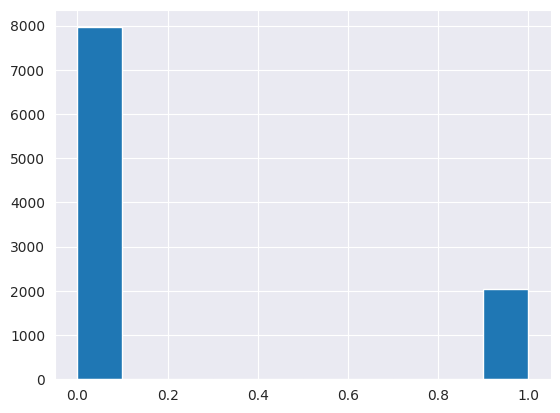

In [6]:
df[TARGET].hist()

Как видно присутсвует дизбаланс классов
Продублируем ряды с недостающими классами

In [7]:
rat = len(df.loc[df[TARGET]==0])//len(df.loc[df[TARGET]==1])
rat

3

<AxesSubplot:>

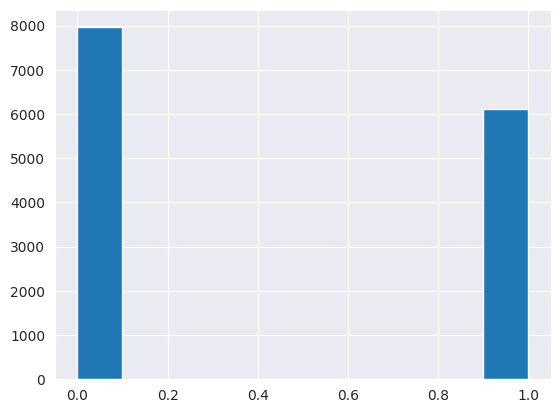

In [8]:
df_1 = df.loc[df[TARGET]==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
df_n = pd.concat([df.loc[df[TARGET]==0], df_1]).sample(frac=1)
df_n[TARGET].hist()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_n, df_n[TARGET], random_state=0)

In [10]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [11]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [12]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
1520,0,1
9081,0,1
2651,0,1


In [13]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [14]:
feats = FeatureUnion(final_transformers)

---

**Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)**

========== LogisticRegression ==========


/tmp/ipykernel_534370/549742759.py:16: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


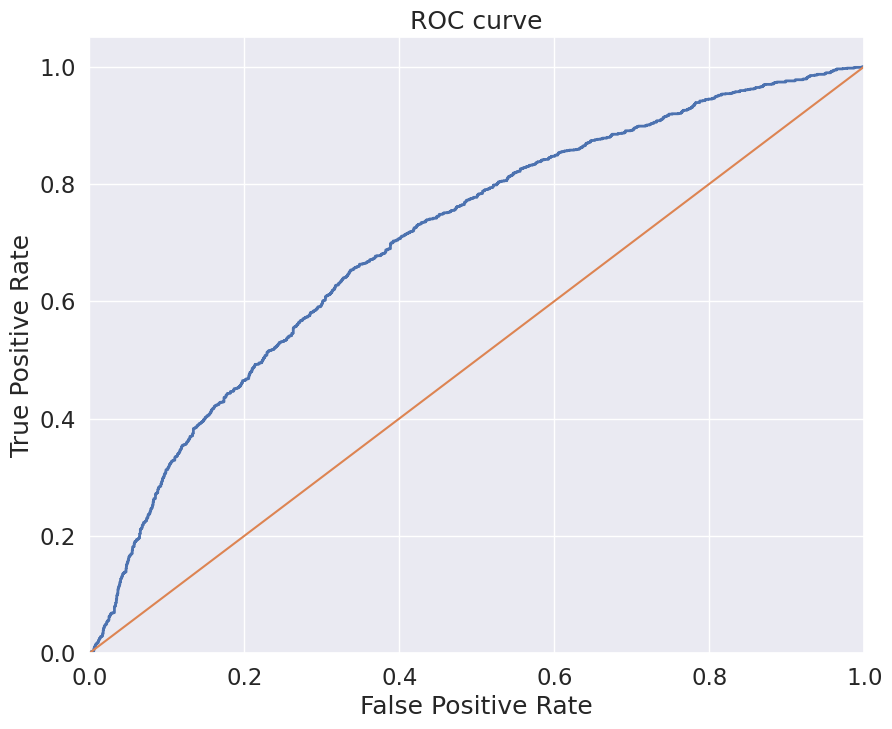

========== GradientBoostingClassifier ==========


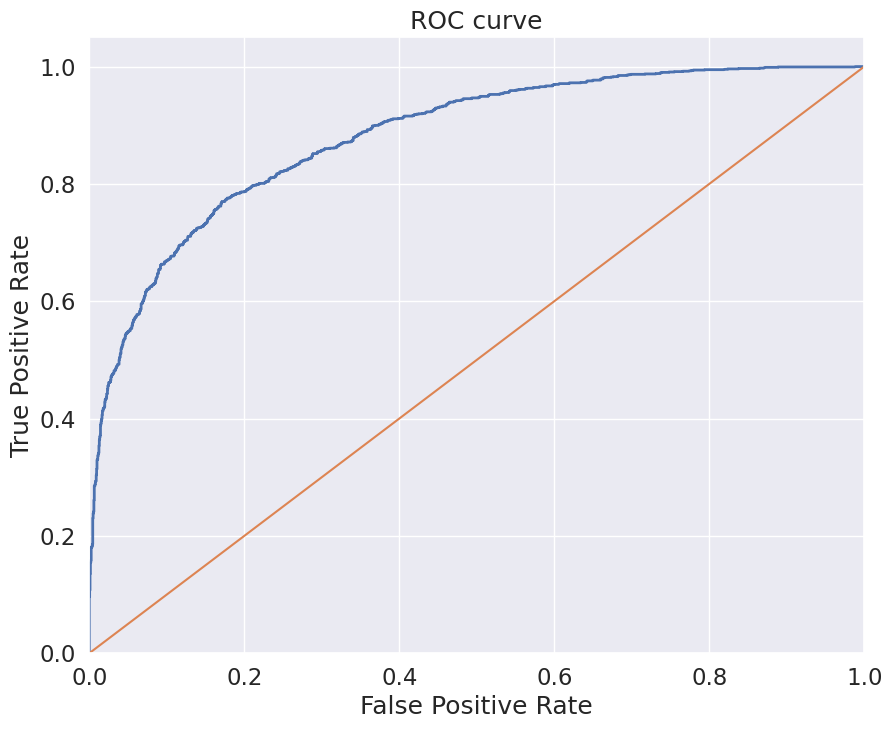

In [16]:
metrics_ = []
for model in (
    LogisticRegression(random_state=42),
    GradientBoostingClassifier(random_state=42)
):
    print('='*10,model.__class__.__name__,'='*10)
    classifier = Pipeline([
        ('features',feats),
        ('classifier', model),
    ])

    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_score)
    fscore = (2 * precision * recall) / (precision + recall)

    ix = np.nanargmax(fscore)

    roc_auc_score_ = metrics.roc_auc_score(y_test, y_score)
    metrics_.append([
        model.__class__.__name__,
        thresholds[ix],
        fscore[ix],
        precision[ix],
        recall[ix],
        roc_auc_score_
    ])
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = metrics.roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()


In [17]:
pd.DataFrame(metrics_,
             columns=('classifier', 'thresholds', 'fscore', 'precision', 'recall', 'roc_auc'))

,classifier,thresholds,fscore,precision,recall,roc_auc
0,LogisticRegression,0.351012,0.645211,0.529362,0.825972,0.703565
1,GradientBoostingClassifier,0.440238,0.771803,0.767776,0.775873,0.880664


**Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)**

Больше всего нас интересует F метрика.
Для дальнейшей работы выбираем модель градиентного бустинга

**Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.**

In [18]:
# Вернем исходные данные
X_train, X_test, y_train, y_test = train_test_split(df, df[TARGET], random_state=0)

In [19]:
def calculate_amount(true_positive:int, false_positive:int, hold_price:float=1, tp_price:float=2):
    return true_positive*tp_price - (true_positive + false_positive)*hold_price

In [20]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_score)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)

confusion_matrix_ = metrics.confusion_matrix(y_test, y_score > thresholds[ix])

calculate_amount(confusion_matrix_[0][0], confusion_matrix_[0][1])

1735

**(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3**

In [21]:
params = {
    "classifier__n_estimators":[5, 50, 300],
    "classifier__max_depth":[1, 3, 5, 8],
    # "classifier__learning_rate":[0.01, 0.1, 1],
    'classifier__min_samples_leaf': [1, 3, 5, 8],
    'classifier__min_samples_split': [2, 4, 8, 10]
}

In [22]:
gscv = GridSearchCV(classifier,
                    param_grid=params,
                    cv=5,
                    refit=False,
                    n_jobs=6)

results = gscv.fit(X_train, y_train)
results.best_params_

{'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 8,
 'classifier__n_estimators': 300}

**(опционально) Еще раз провести оценку экономической эффективности**

In [23]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(
        random_state=42,
        max_depth=3,
        min_samples_split=8,
        min_samples_leaf=1,
        n_estimators=300
    )),
])

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_score)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)

confusion_matrix_ = metrics.confusion_matrix(y_test, y_score > thresholds[ix])

calculate_amount(confusion_matrix_[0][0], confusion_matrix_[0][1])

1701